# Setup

## Libraries

In [1]:
# using LinearAlgebra
using SparseArrays
# using Random
using CairoMakie
# using Statistics
# using ProgressMeter
using DataFrames
using DelimitedFiles

In [2]:
include("EchoStateNetworks.jl")
using .EchoStateNetworks
include("ONReservoir.jl")
using .ONReservoir
include("TurningError.jl")
using .TurningError
include("TestingFunctions.jl")
using .TestingFunctions

## Read in Lorenz testing data

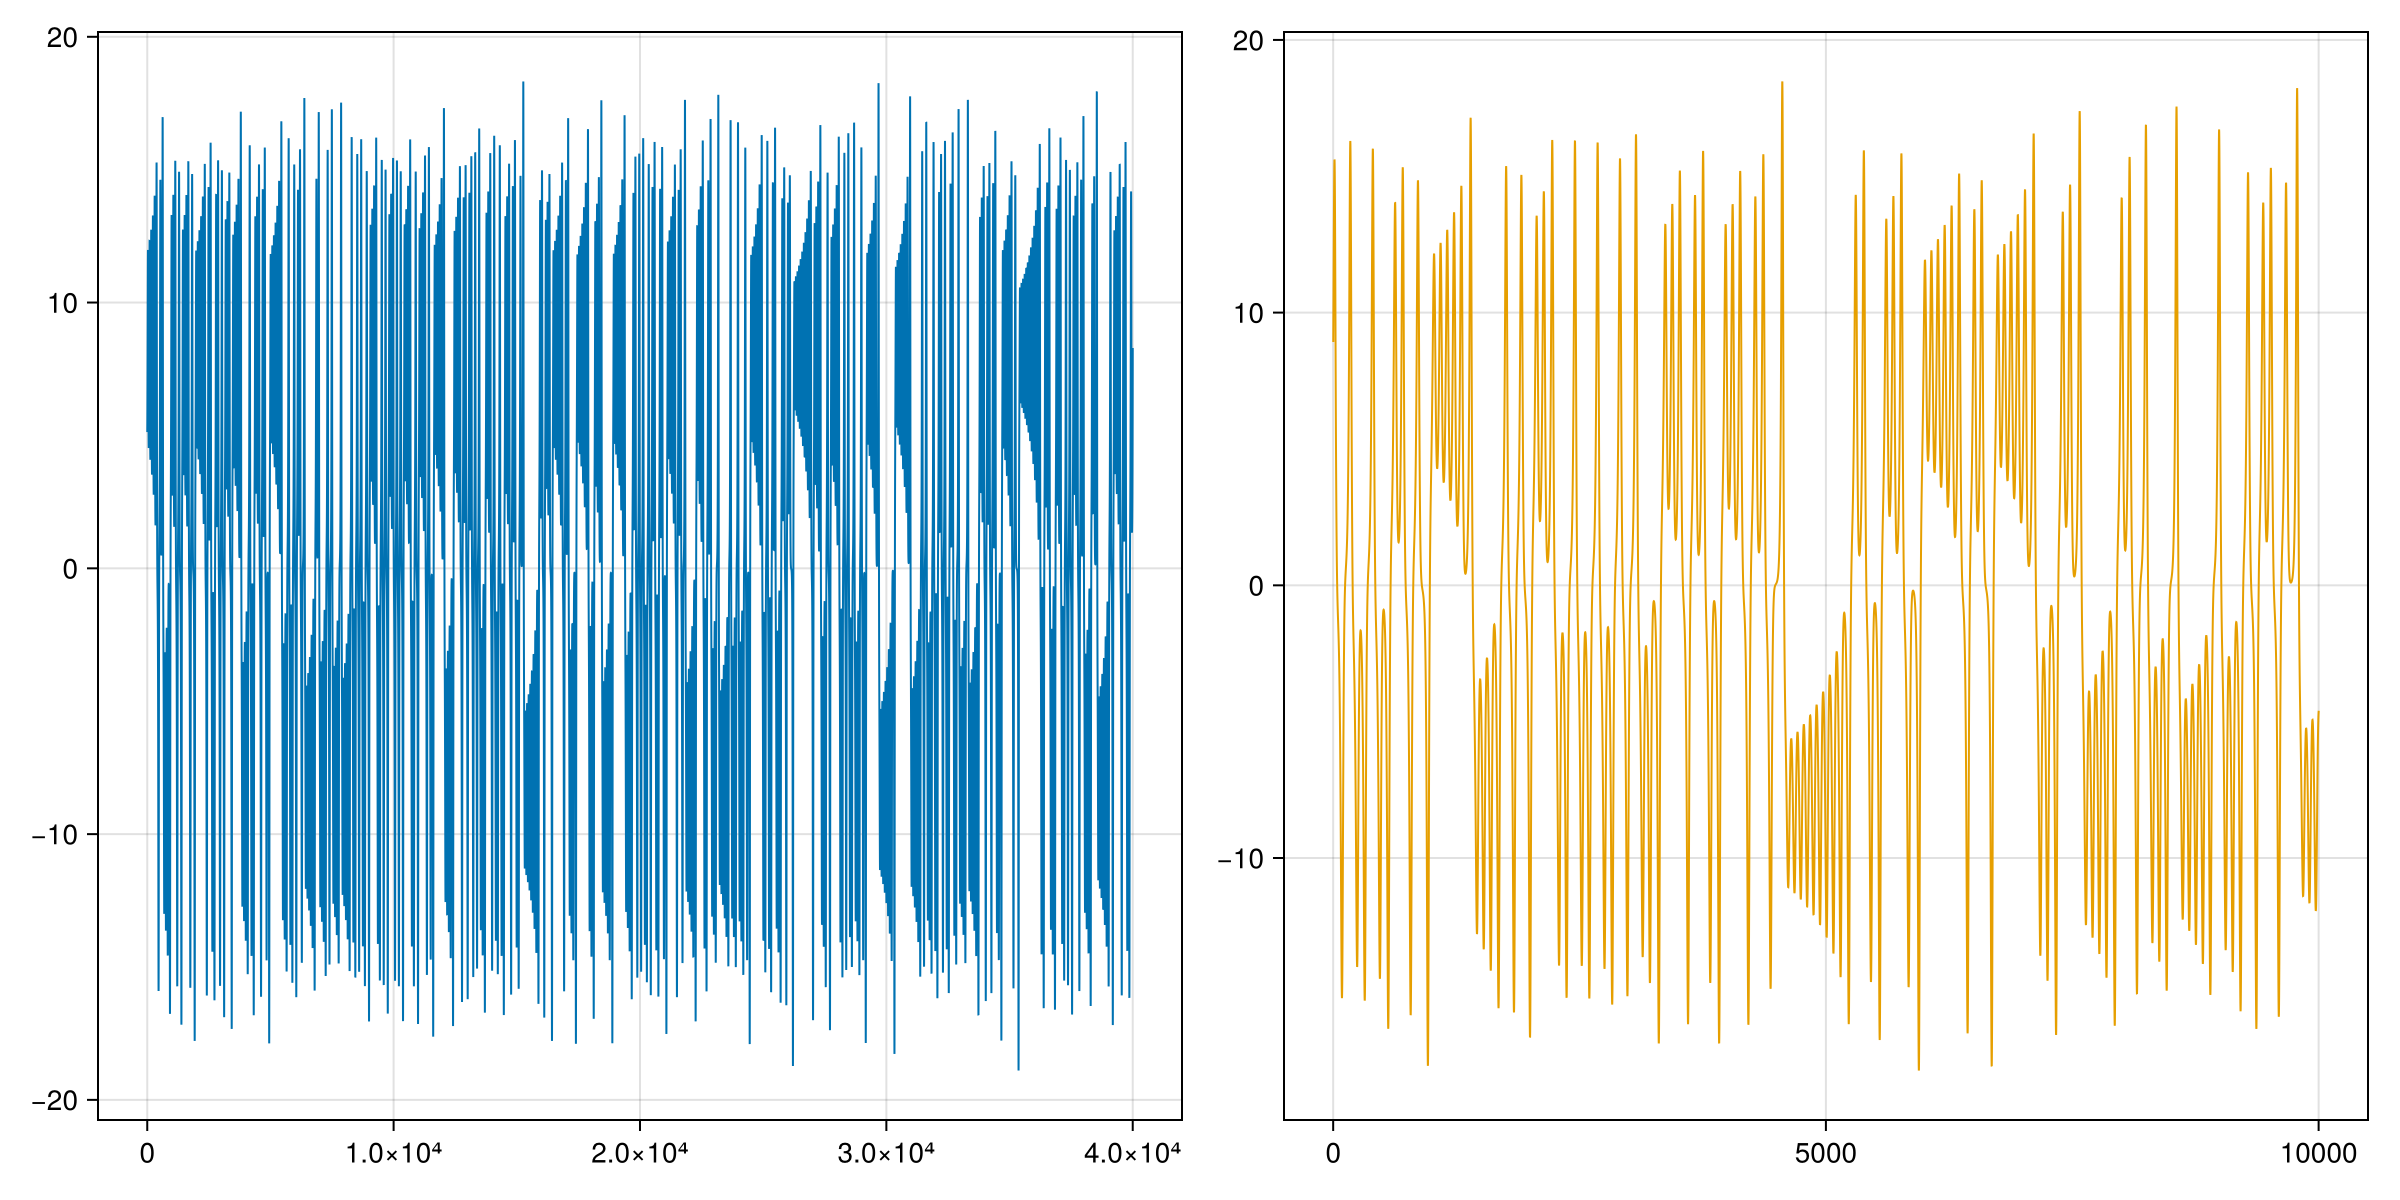

In [3]:
lo_train = vec(readdlm("lorenz_train.txt"))
lo_test = vec(readdlm("lorenz_test.txt"))

fig = Figure( size = (1200,600) )
lines!(Axis(fig[1,1]), lo_train; linewidth = 1.0, color = Cycled(1))
lines!(Axis(fig[1,2]), lo_test; linewidth = 1.0, color = Cycled(2))
fig

# Demonstrations

## Testing ON and reservoir creation

In [4]:
test_ON_part_adjacency = [
    0.7 0.1 0.2;
    0 0.7 0.3;
    0.4 0 0.6
]

k = 8
d = 3
ρ = 2.0
α = 1.0
η = 1/maximum(lo_train)
β = 0.001

ESN_params = create_ESN_params(k, d, ρ, α, η, β, num_partitions=3, ON_part_adjacency=test_ON_part_adjacency)

DataFrame(ESN_params.V_rec, :auto)

24×24 DataFrame
 Row │ x1         x2        x3        x4         x5         x6        x7       ⋯
     │ Float64    Float64   Float64   Float64    Float64    Float64   Float64  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.0        0.0       0.804953  0.0        0.0634396  0.0       0.0      ⋯
   2 │ 0.0        0.0       0.255819  0.0        0.0        0.030217  0.0
   3 │ 0.804953   0.255819  0.0       0.295958   0.0        0.0       0.0
   4 │ 0.0        0.0       0.295958  0.0        0.0994971  0.0       0.0
   5 │ 0.0634396  0.0       0.0       0.0994971  0.0        0.297305  0.0      ⋯
   6 │ 0.0        0.030217  0.0       0.0        0.297305   0.0       0.0
   7 │ 0.0        0.0       0.0       0.0        0.0        0.0       0.0
   8 │ 0.0        0.0       0.491652  0.115152   0.0        0.348659  0.0
   9 │ 0.0        0.0       0.0       0.0        0.0        0.0       0.0      ⋯
  10 │ 0.0        0.0       0.0       0.0        0.0        0.0       0.0
  11 │ 0.0        0.0       0.0       0.0        0.0        0.0       0.0
  ⋮  │     ⋮         ⋮         ⋮          ⋮          ⋮         ⋮         ⋮     ⋱
  15 │ 0.0        0.0       0.0       0.0        0.0        0.0       0.0
  16 │ 0.0        0.0       0.0       0.0        0.0        0.0       0.0      ⋯
  17 │ 0.483785   0.0       0.0       0.0        0.0        0.0       0.0
  18 │ 0.0        0.483785  0.0       0.0        0.0        0.0       0.0
  19 │ 0.0        0.0       0.483785  0.0        0.0        0.0       0.0
  20 │ 0.0        0.0       0.0       0.483785   0.0        0.0       0.0      ⋯
  21 │ 0.0        0.0       0.0       0.0        0.483785   0.0       0.0
  22 │ 0.0        0.0       0.0       0.0        0.0        0.483785  0.0
  23 │ 0.0        0.0       0.0       0.0        0.0        0.0       0.483785
  24 │ 0.0        0.0       0.0       0.0        0.0        0.0       0.0      ⋯
                                                   17 columns and 3 rows omitted

In [5]:
m = 3
k = 4
part_connection=0.5
d = k*0.05
ρ = 1.2
α = 1.0
η = 1/maximum(lo_train)
β = 0.001
w = 1
τ = 2

window_size = (m-1)*τ
    
part_symbols_train, unique_partitions_train = create_ordinal_partition(lo_train, m, w, τ)
trans_adjacency_matrix = create_transition_matrix(part_symbols_train)
num_partitions = length(unique_partitions_train)
# trans_adjacency_map = trans_adjacency_matrix_to_map(trans_adjacency_matrix, num_partitions)

ESN_params = create_ESN_params(k, d, ρ, α, η, β, num_partitions=num_partitions, ON_part_adjacency=trans_adjacency_matrix)

R, train_states = train_one_step_pred(lo_train, ESN_params, partition_symbols=part_symbols_train)


part_symbols_test, unique_partitions_test = create_ordinal_partition(lo_test, m, w, τ, unique_partitions=unique_partitions_train)
preds, test_states = one_step_pred(lo_test, ESN_params, R, S = train_states[end,:], partition_symbols=part_symbols_test)

([0.0, 0.0, 0.0, 0.0, 11.94216107323059, 12.529514396370113, 13.137866925871345, 13.662430802228824, 14.139329723364808, 14.540520078446772  …  -5.522815323272773, -5.293198291708698, -5.08795971416842, -4.907129631174046, -4.750517056720538, -4.617766046920493, -4.508405481241601, -4.421883279184944, -4.357611913922247, -4.3149903517705495], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; -0.5572747018299123 0.830795295215315 … 0.0 0.0; -0.5571569459515736 0.8290859052836395 … 0.0 0.0])

In [6]:
trans_adjacency_matrix

6×6 Matrix{Float64}:
 0.977899   0.0219441  0.000157117  0.0       0.0        0.0
 0.0        0.007109   0.985782     0.007109  0.0        0.0
 0.0        0.0        0.007109     0.992891  0.0        0.0
 0.0        0.0        0.0          0.978036  0.0217561  0.000208192
 0.0047619  0.0        0.0          0.0       0.0047619  0.990476
 0.990566   0.0        0.0          0.0       0.0        0.00943396

In [7]:
DataFrame(ESN_params.V_rec, :auto)

24×24 DataFrame
 Row │ x1          x2          x3          x4          x5         x6         x ⋯
     │ Float64     Float64     Float64     Float64     Float64    Float64    F ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.0         0.0         0.0         0.0         0.0378733  0.0        0 ⋯
   2 │ 0.0         0.0         0.0         1.19503     0.0        0.0378733  0
   3 │ 0.0         0.0         0.0         0.0         0.0        0.0        0
   4 │ 0.0         1.19503     0.0         0.0         0.0        0.0        0
   5 │ 0.0         0.0         0.0         0.0         0.0        0.0        0 ⋯
   6 │ 0.0         0.0         0.0         0.0         0.0        0.0        0
   7 │ 0.0         0.0         0.0         0.0         0.0        0.0        0
   8 │ 0.0         0.0         0.0         0.0         0.0        0.0        0
   9 │ 0.0         0.0         0.0         0.0         0.0        0.0        0 ⋯
  10 │ 0.0         0.0         0.0         0.0         0.0        0.0        0
  11 │ 0.0         0.0         0.0         0.0         0.0        0.0        0
  ⋮  │     ⋮           ⋮           ⋮           ⋮           ⋮          ⋮        ⋱
  15 │ 0.0         0.0         0.0         0.0         0.0        0.0        0
  16 │ 0.0         0.0         0.0         0.0         0.0        0.0        0 ⋯
  17 │ 0.00821858  0.0         0.0         0.0         0.0        0.0        0
  18 │ 0.0         0.00821858  0.0         0.0         0.0        0.0        0
  19 │ 0.0         0.0         0.00821858  0.0         0.0        0.0        0
  20 │ 0.0         0.0         0.0         0.00821858  0.0        0.0        0 ⋯
  21 │ 1.70962     0.0         0.0         0.0         0.0        0.0        0
  22 │ 0.0         1.70962     0.0         0.0         0.0        0.0        0
  23 │ 0.0         0.0         1.70962     0.0         0.0        0.0        0
  24 │ 0.0         0.0         0.0         1.70962     0.0        0.0        0 ⋯
                                                   18 columns and 3 rows omitted

## Demonstration of turning point error

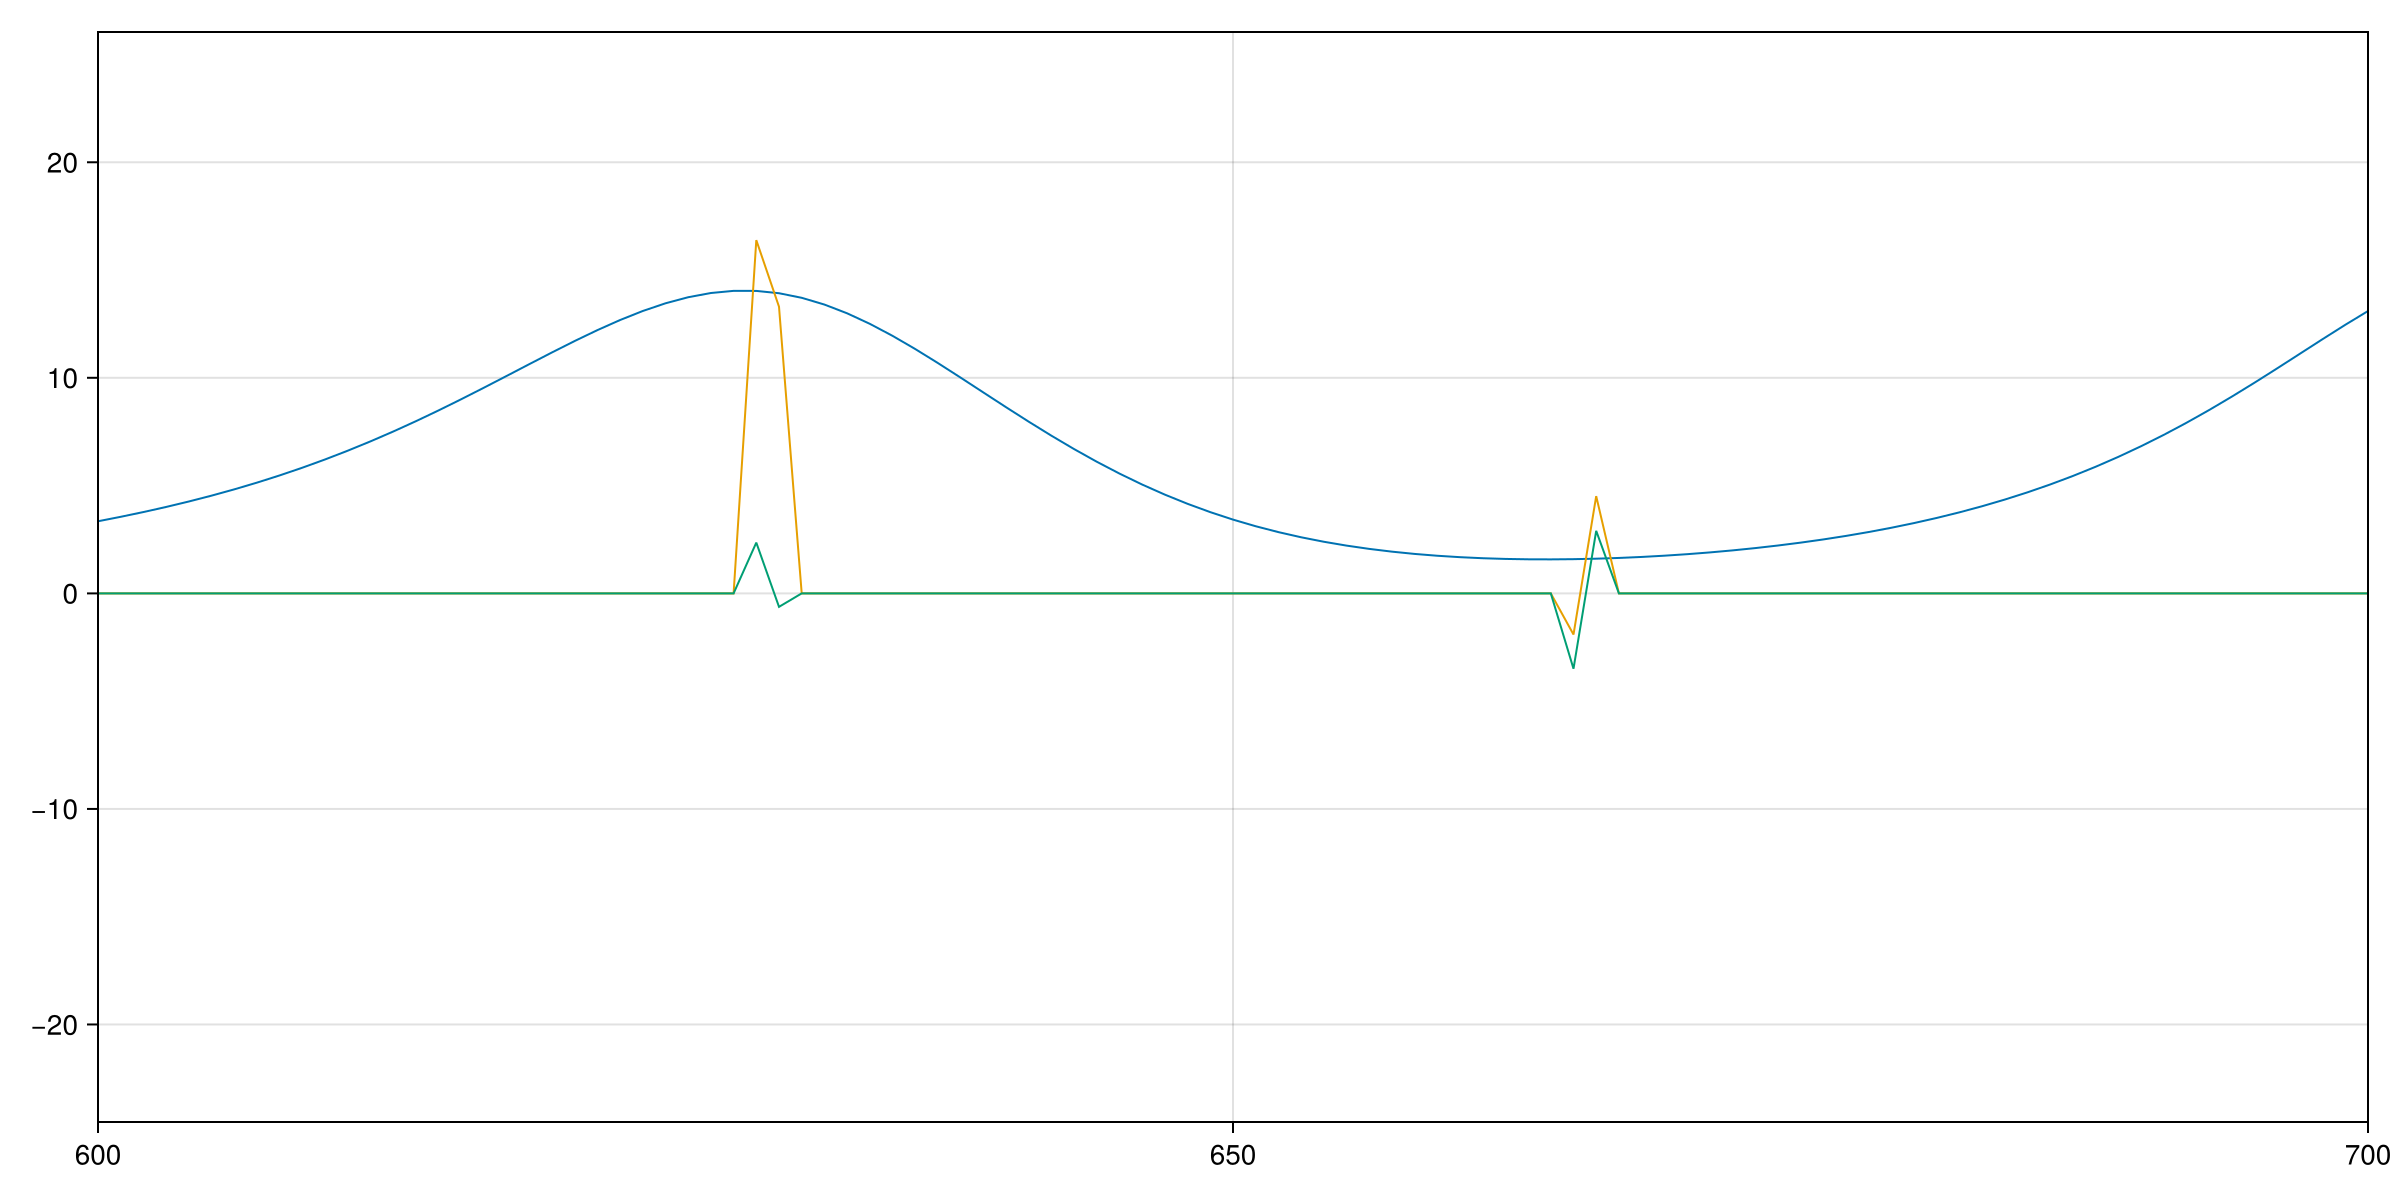

In [8]:
test_preds = lo_test + 3 * randn(length(lo_test))

test_mask = create_turning_partition_mask(lo_test, 4, 1, 1)
error = test_preds .- lo_test

fig = Figure( size = (1200,600))

ax1 = Axis(fig[1,1])
lines!(ax1, lo_test; linewidth = 1.0, color = Cycled(1))
lines!(ax1, test_preds .* test_mask; linewidth = 1.0, color = Cycled(2))
lines!(ax1, error .* test_mask; linewidth = 1.0, color = Cycled(3))

xlims!(600,700)

fig

<!-- # Single step predictions -->

### Equal size of overall reservoir

#### 600 total size

Created reservoir of size: (600,)
Created reservoir of size: (600,)
Overall RMSE:
    Vanilla: 0.4330059748193305
    Ordinal network reservoir: 0.4279421375193523
Turning partition RMSE:
    Vanilla: 0.33116513364933736
    Ordinal network reservoir: 0.3393102759424906


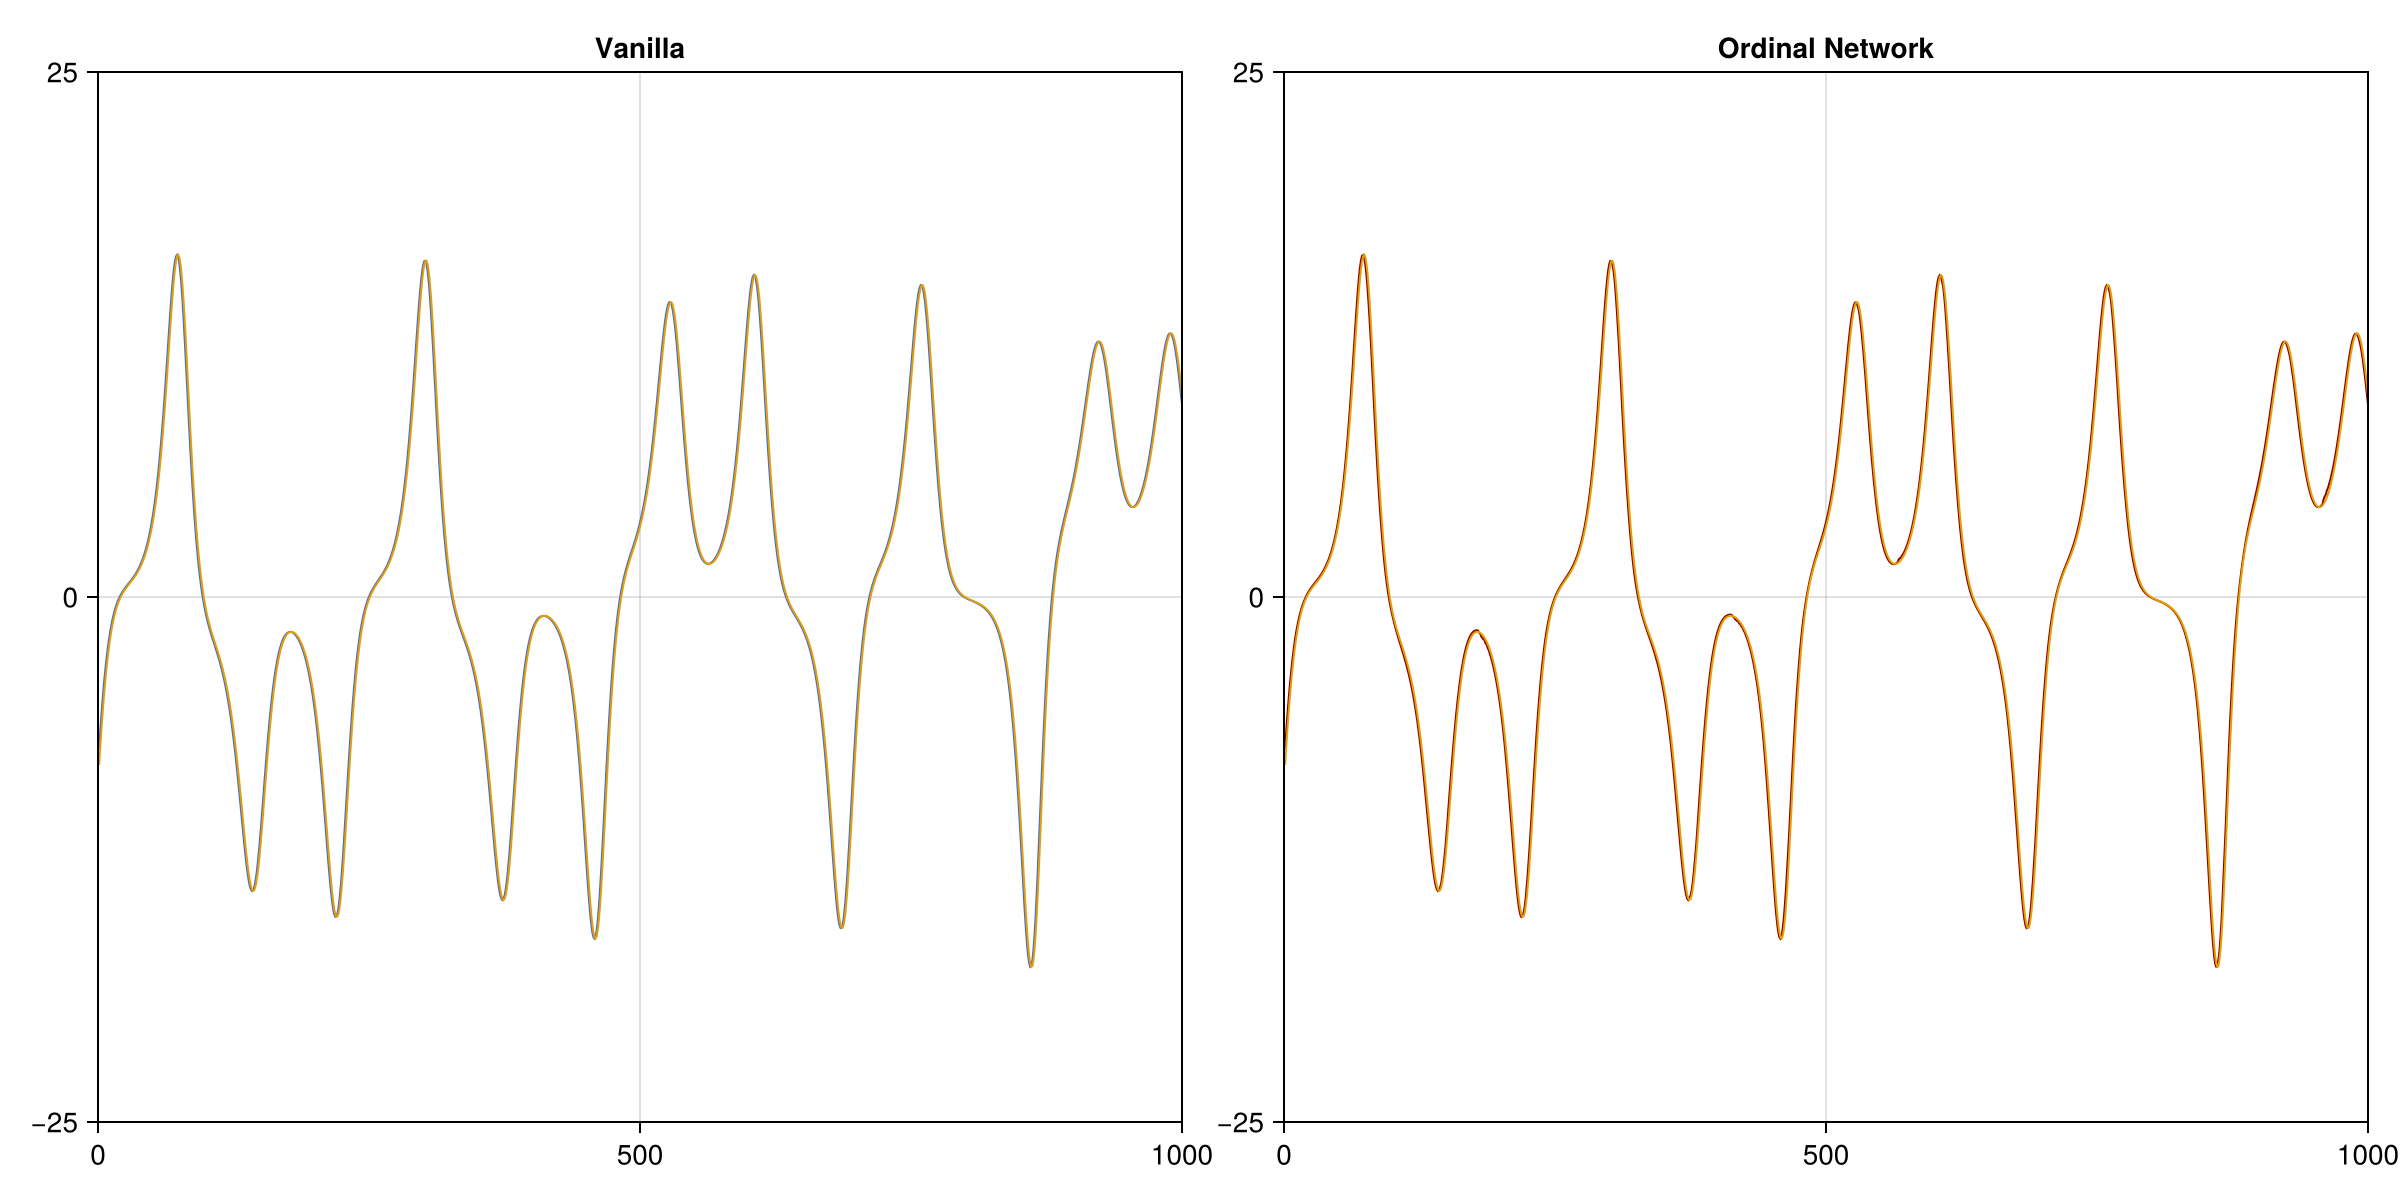

In [9]:
test_single_step(lo_train, lo_test, 3, 100; from=0, to=1000, ignore_first=100)

Created reservoir of size: (300,)
Created reservoir of size: (300,)
Overall RMSE:
    Vanilla: 0.43302684656396373
    Ordinal network reservoir: 0.4301525231791416
Turning partition RMSE:
    Vanilla: 0.3312723111095097
    Ordinal network reservoir: 0.34131394025441053


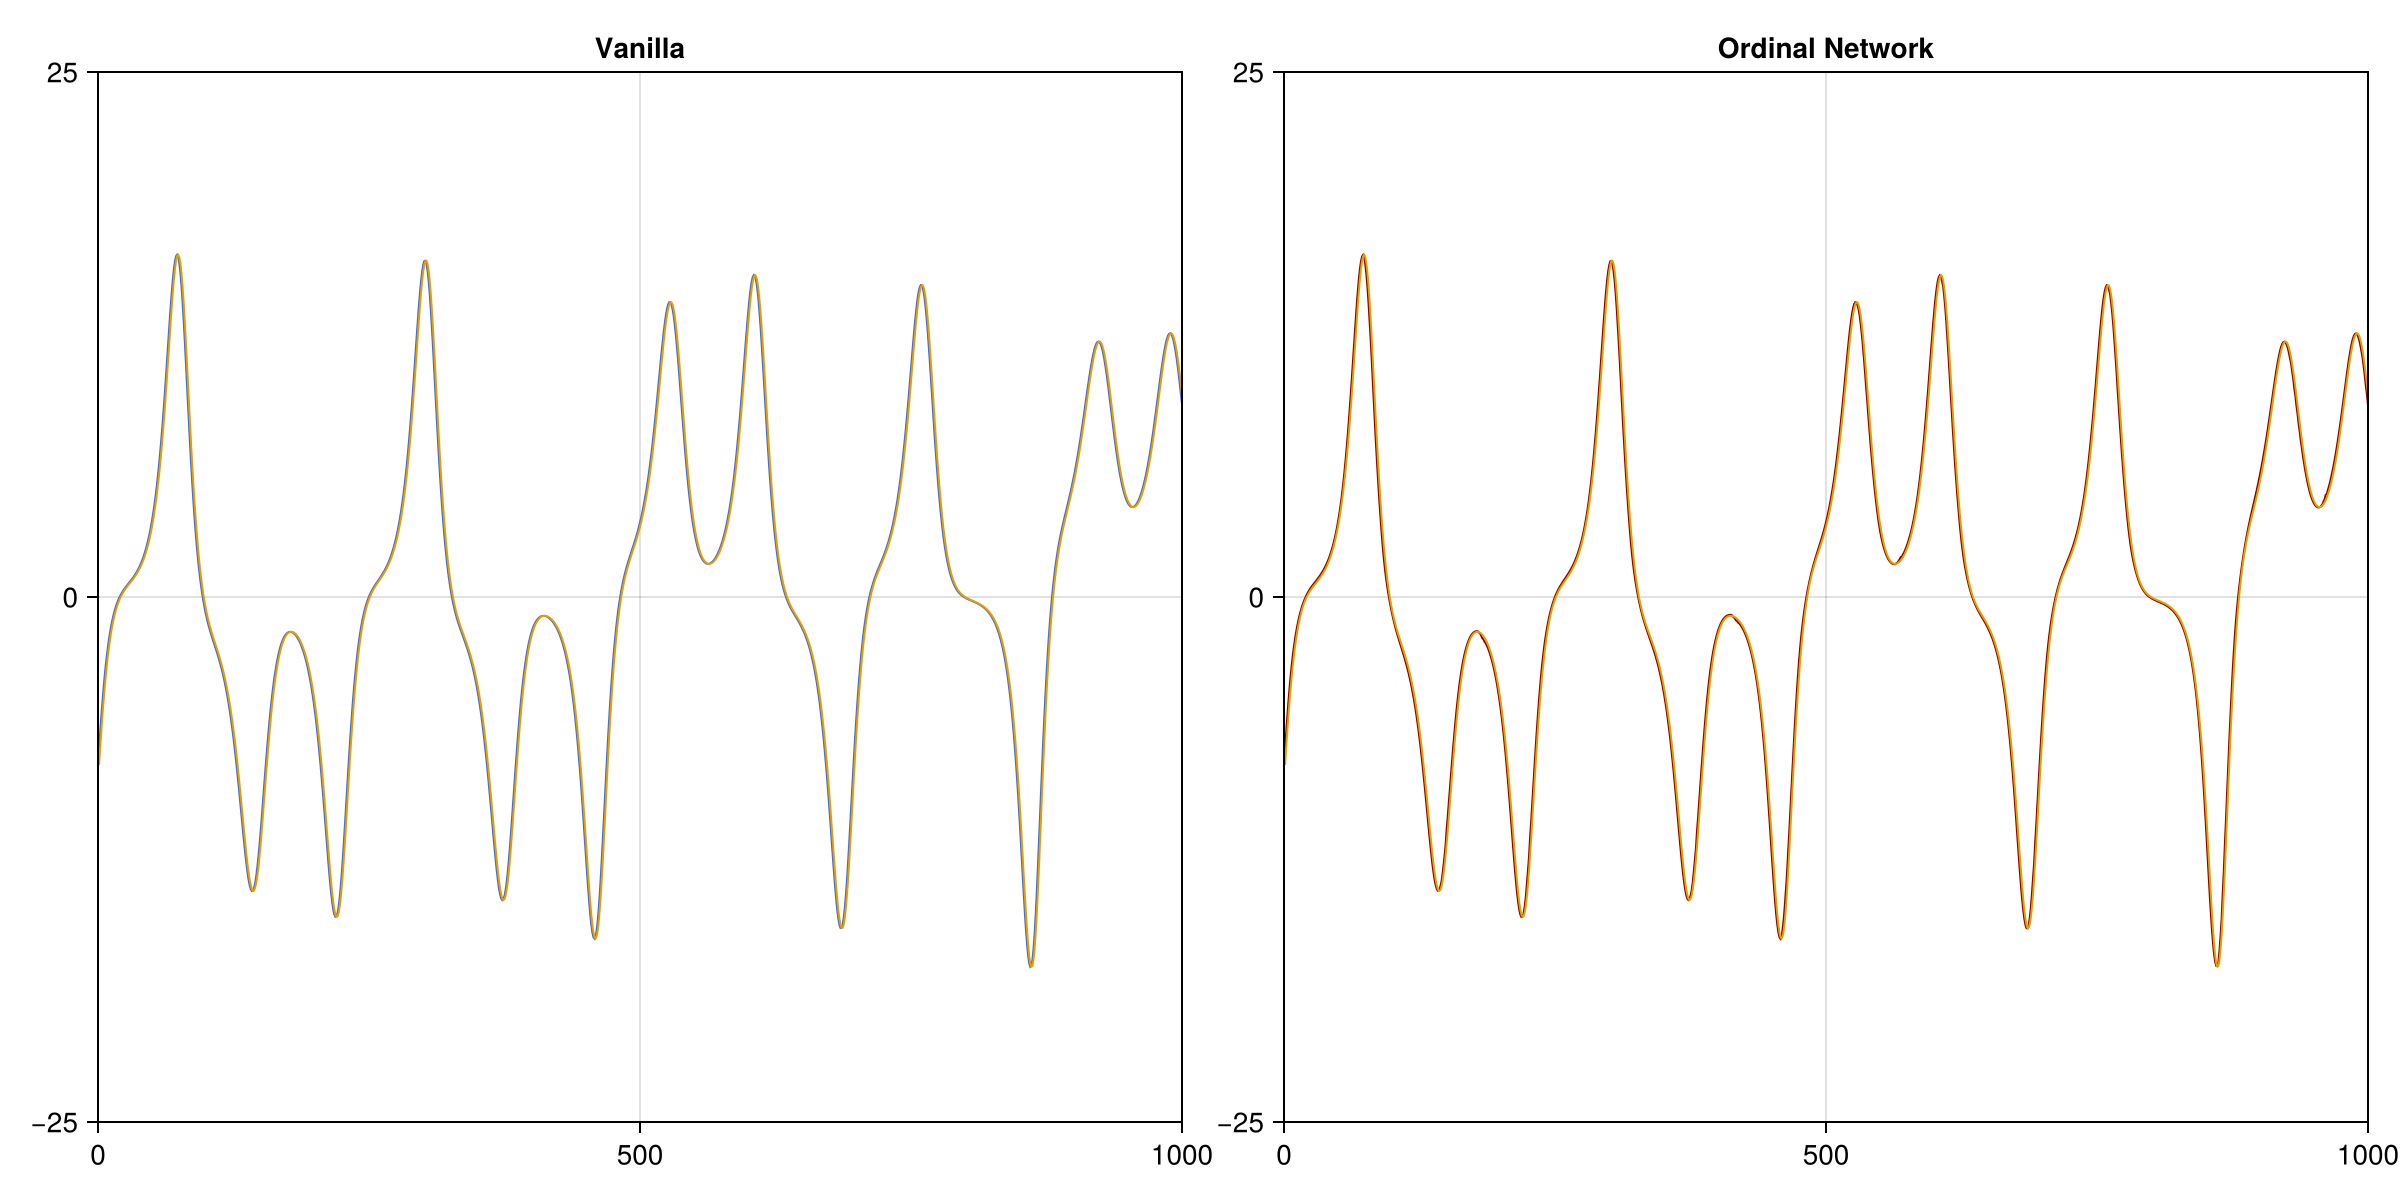

In [11]:
test_single_step(lo_train, lo_test, 3, 50; from=0, to=1000, ignore_first=100)

Created reservoir of size: (1200,)
Created reservoir of size: (1200,)
Overall RMSE:
    Vanilla: 0.4330222077976702
    Ordinal network reservoir: 0.4330249923239505
Turning partition RMSE:
    Vanilla: 0.3321025374370691
    Ordinal network reservoir: 0.33355423244311466


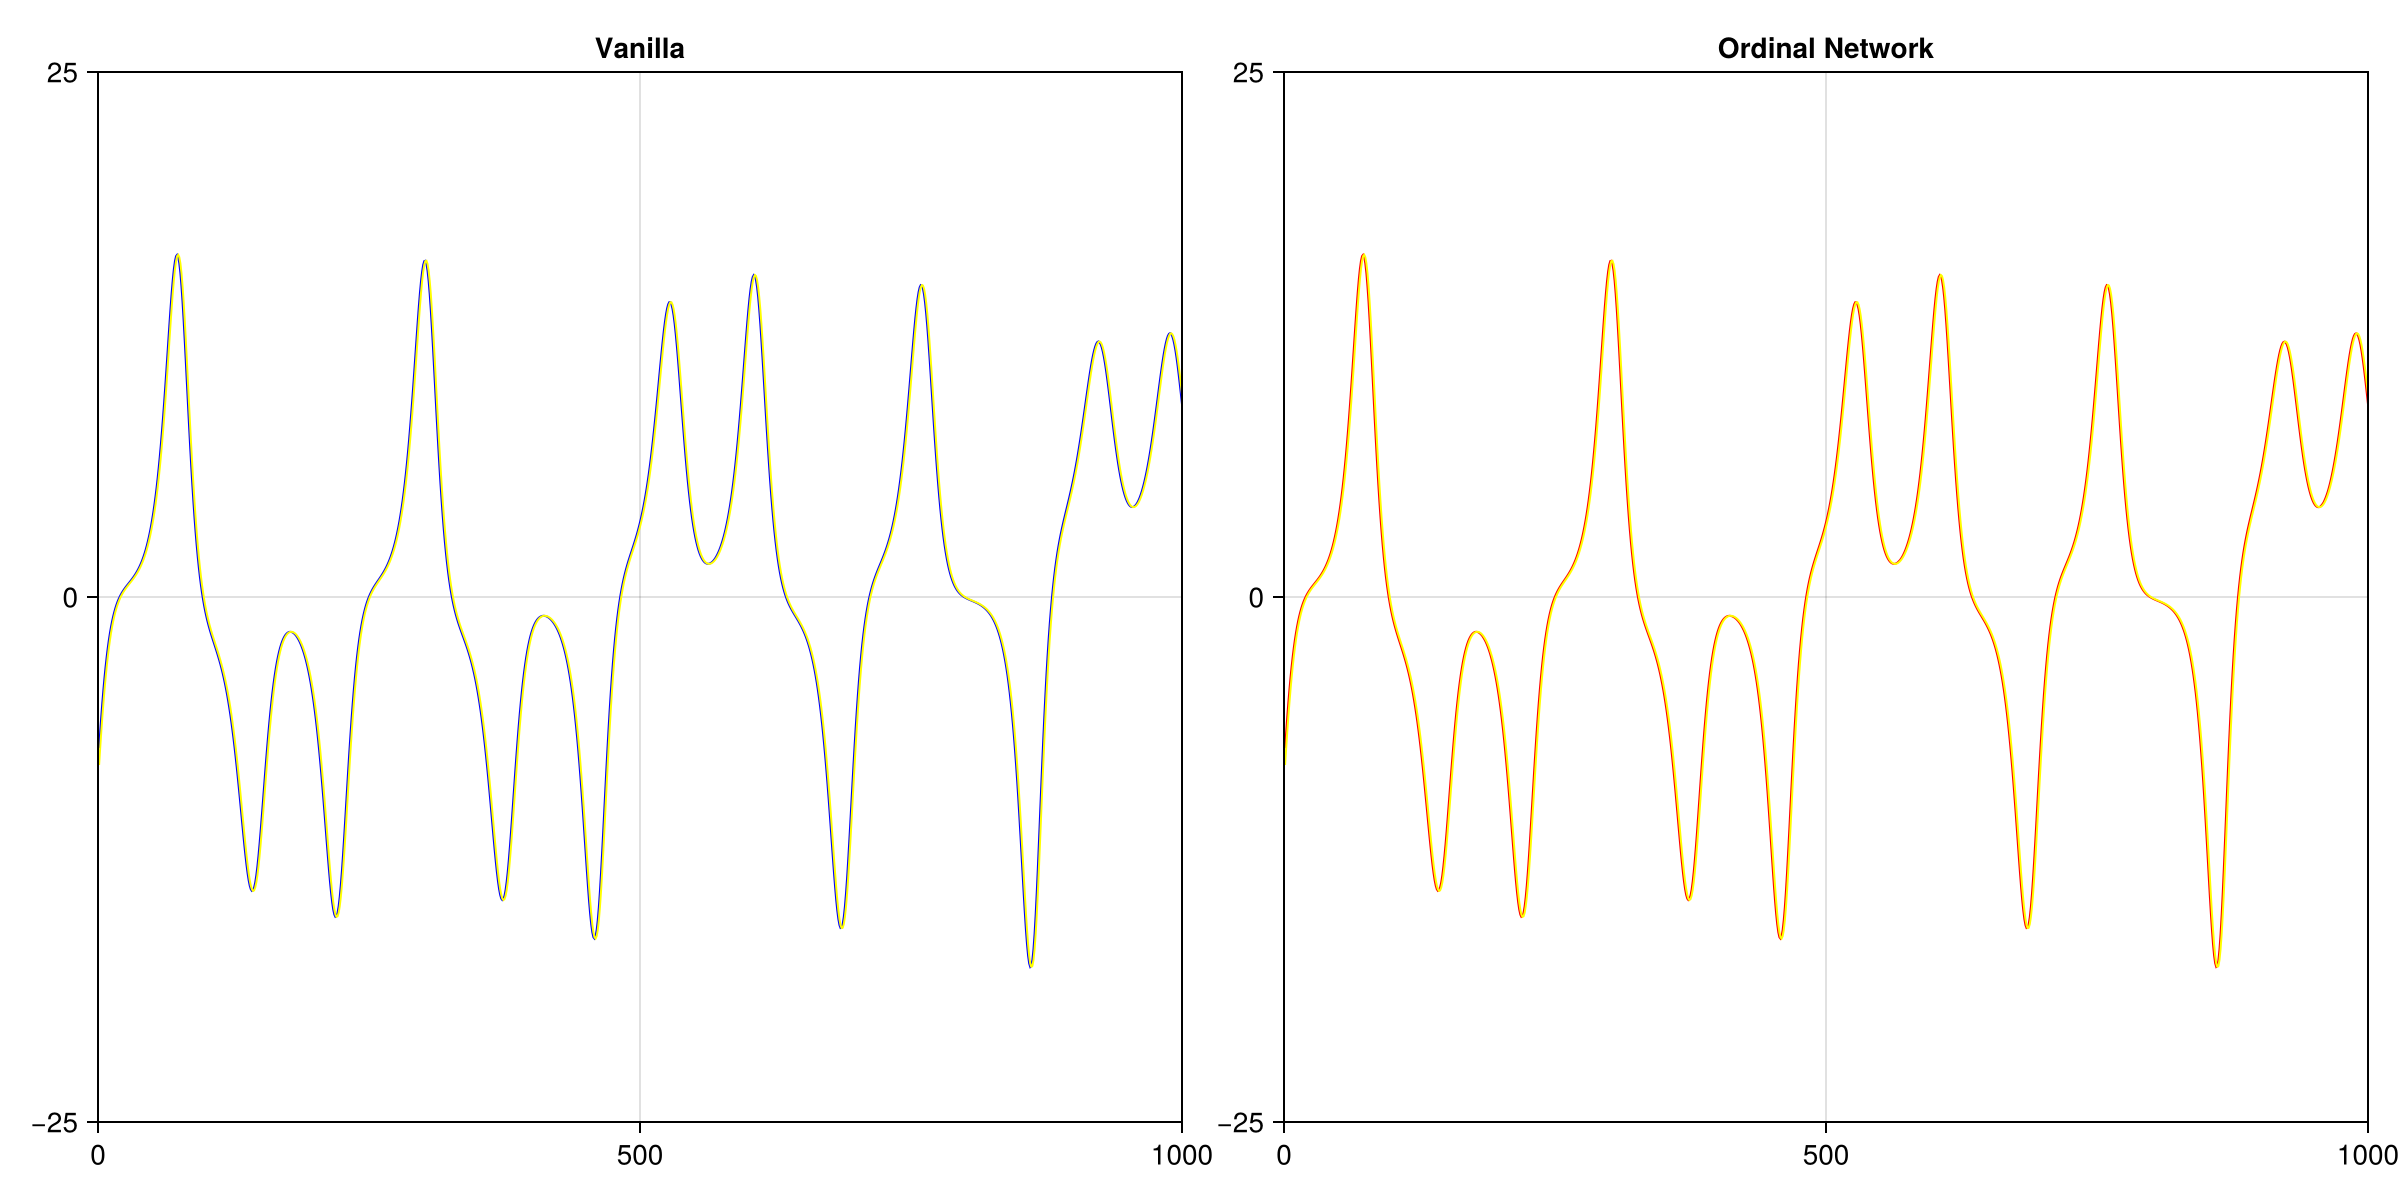

In [11]:
test_single_step(lo_train, lo_test, 3, 200; from=0, to=1000, ignore_first=100)

### Equal k

#### k = 100

Created reservoir of size: (600,)
Created reservoir of size: (100,)
Overall RMSE:
    Vanilla: 0.4329361483788819
    Ordinal network reservoir: 0.43301408110404965
Turning partition RMSE:
    Vanilla: 0.33105812345557417
    Ordinal network reservoir: 0.3332186754194795


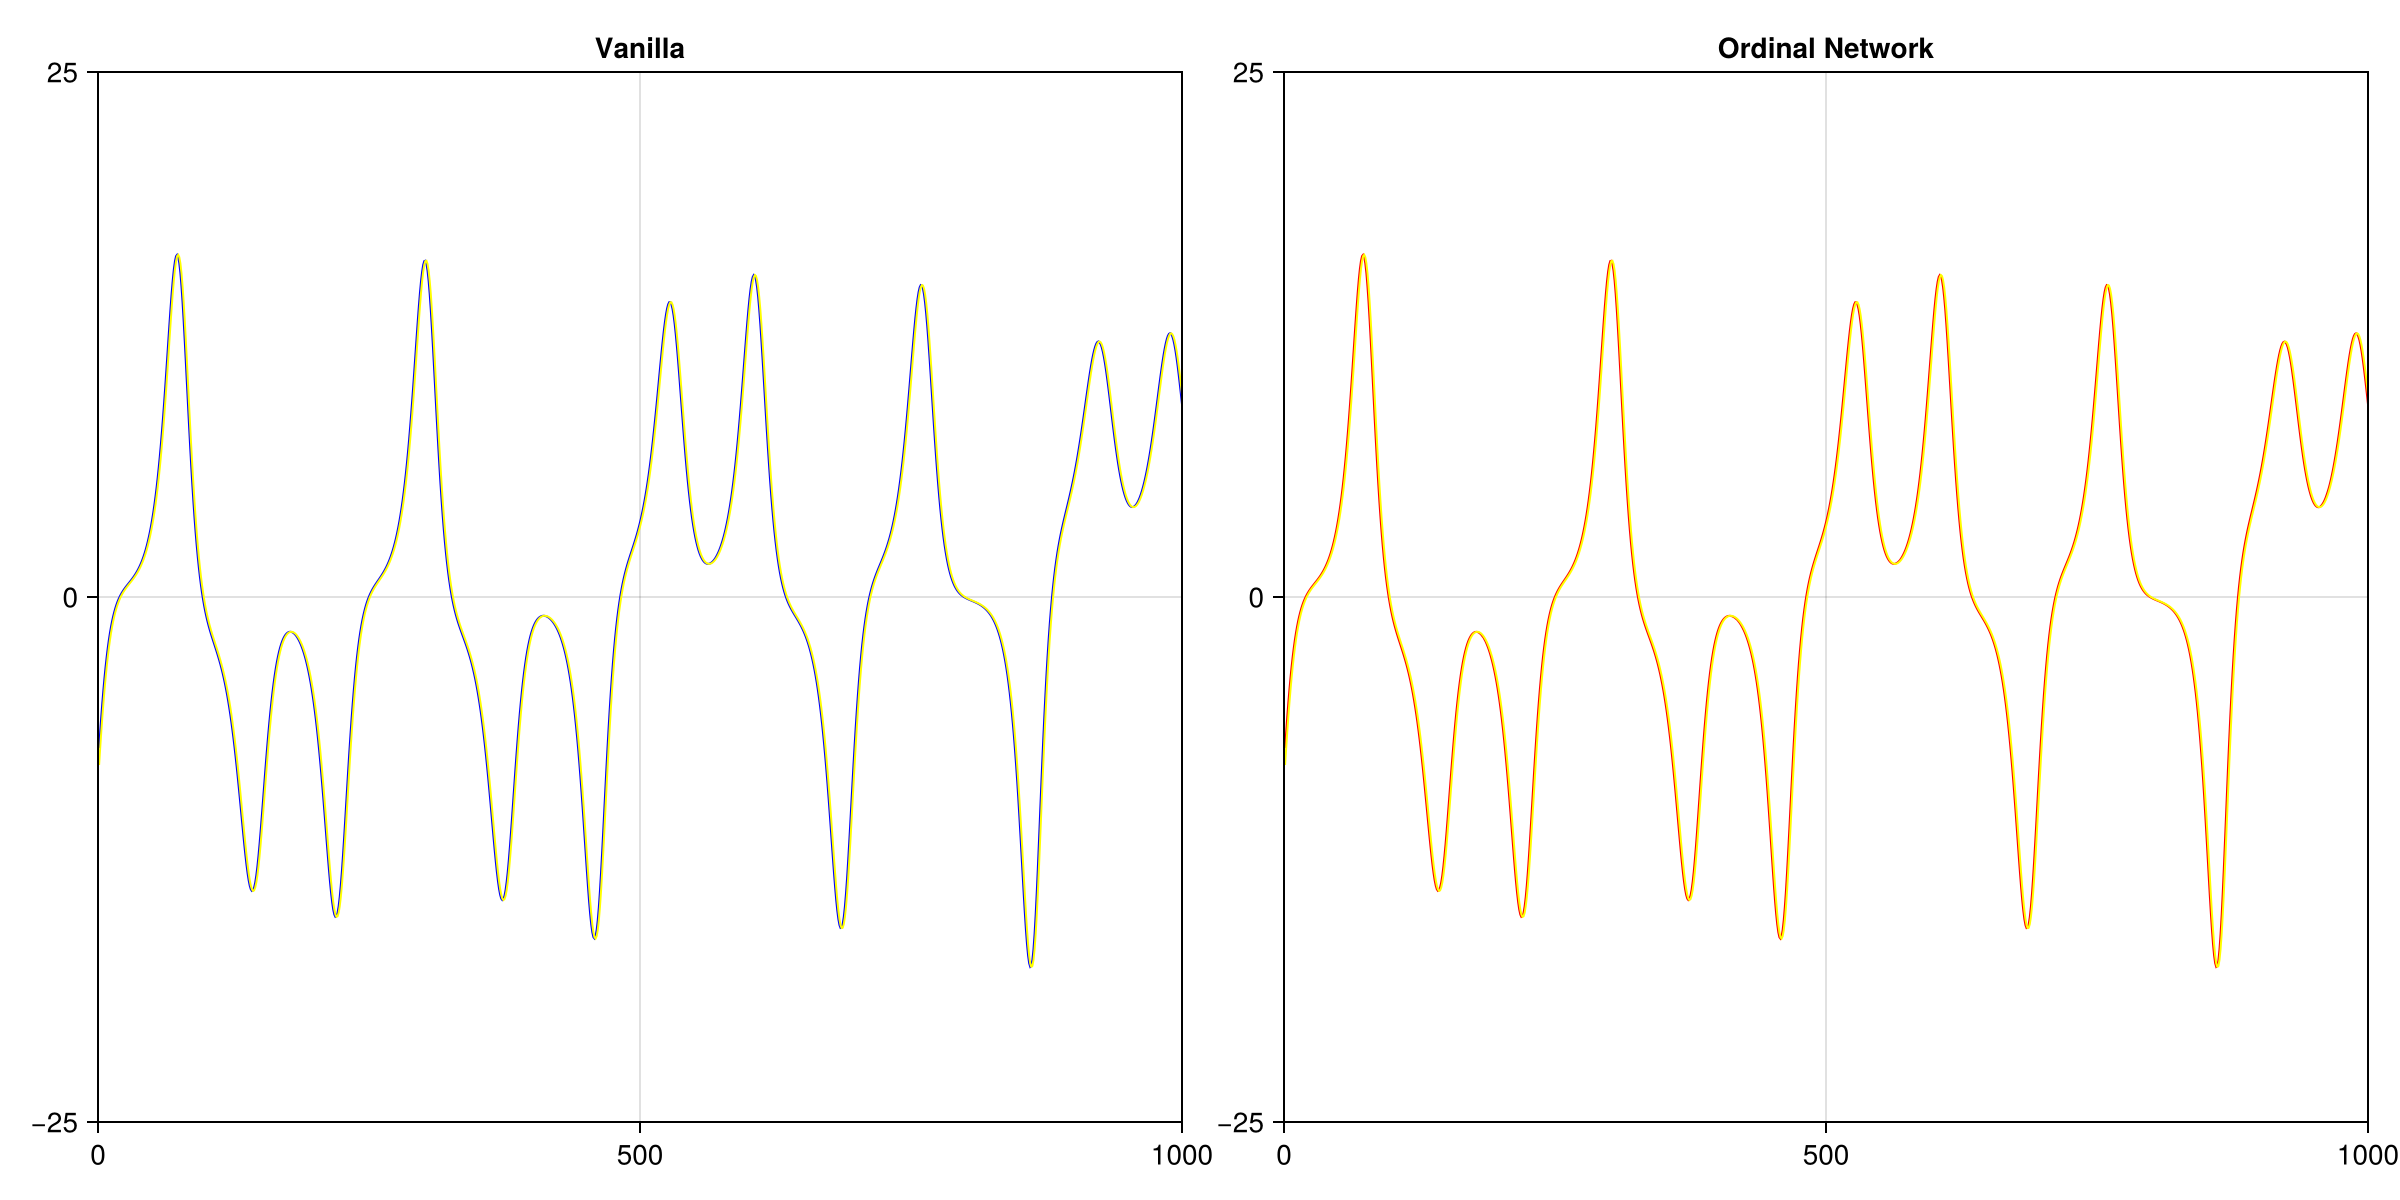

In [12]:
test_single_step(lo_train, lo_test, 3, 100; from=0, to=1000, ignore_first=100, equal_total_k=false)

#### k = 500

Created reservoir of size: (3000,)
Created reservoir of size: (500,)
Overall RMSE:
    Vanilla: 0.432956859228731
    Ordinal network reservoir: 0.4330002718175323
Turning partition RMSE:
    Vanilla: 0.3309965665310794
    Ordinal network reservoir: 0.3337698993951789


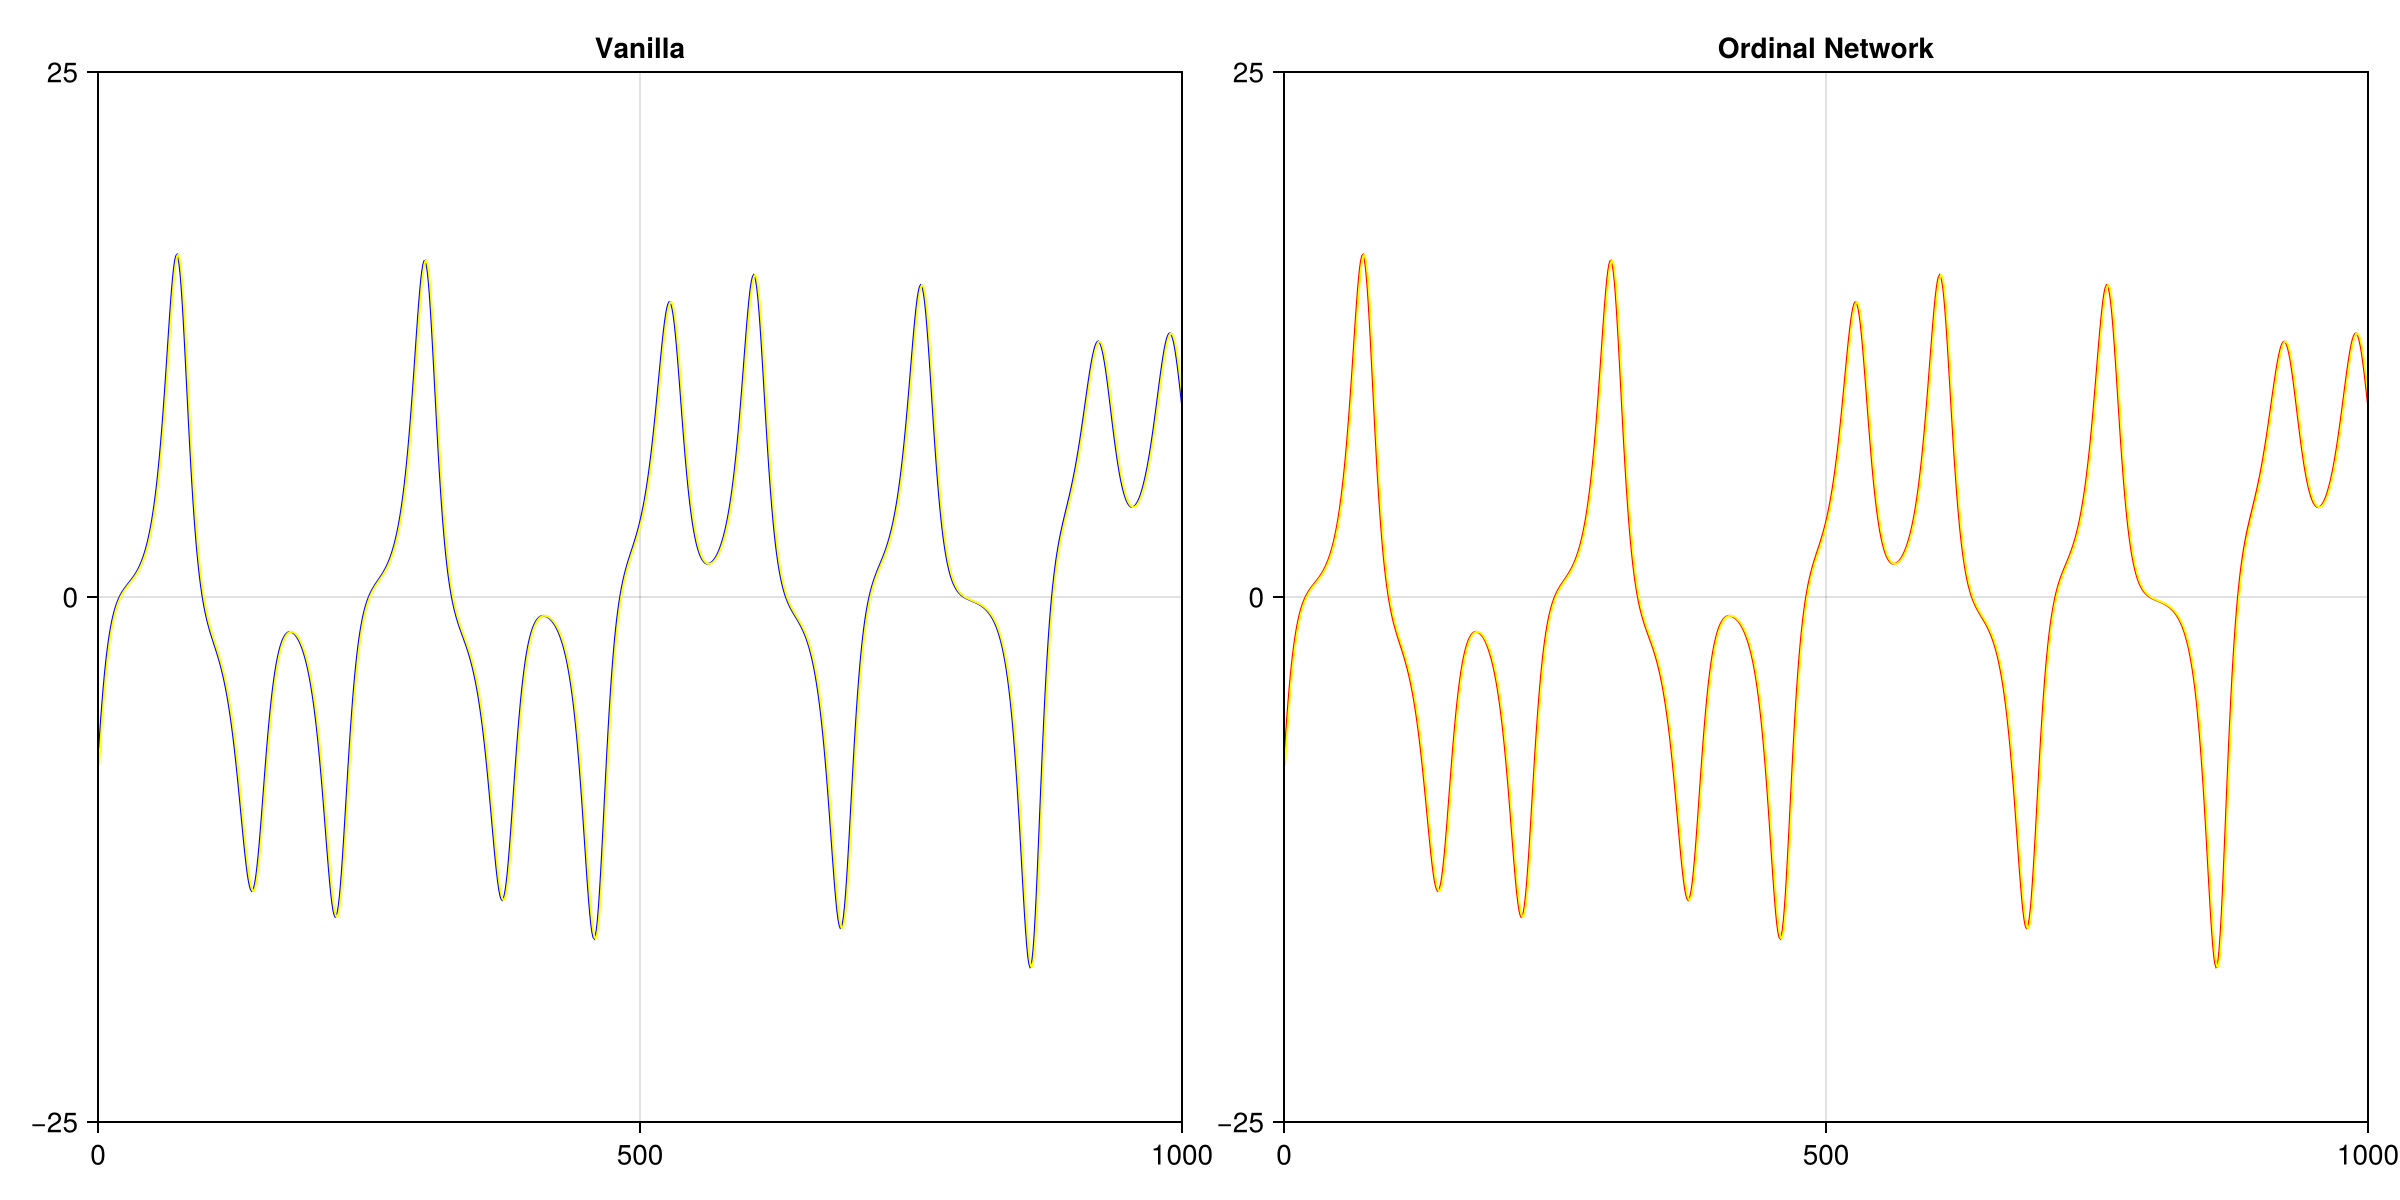

In [13]:
test_single_step(lo_train, lo_test, 3, 500; from=0, to=1000, ignore_first=100, equal_total_k=false)

# Freerun predictions

Created reservoir of size: (390,)
Created reservoir of size: (390,)


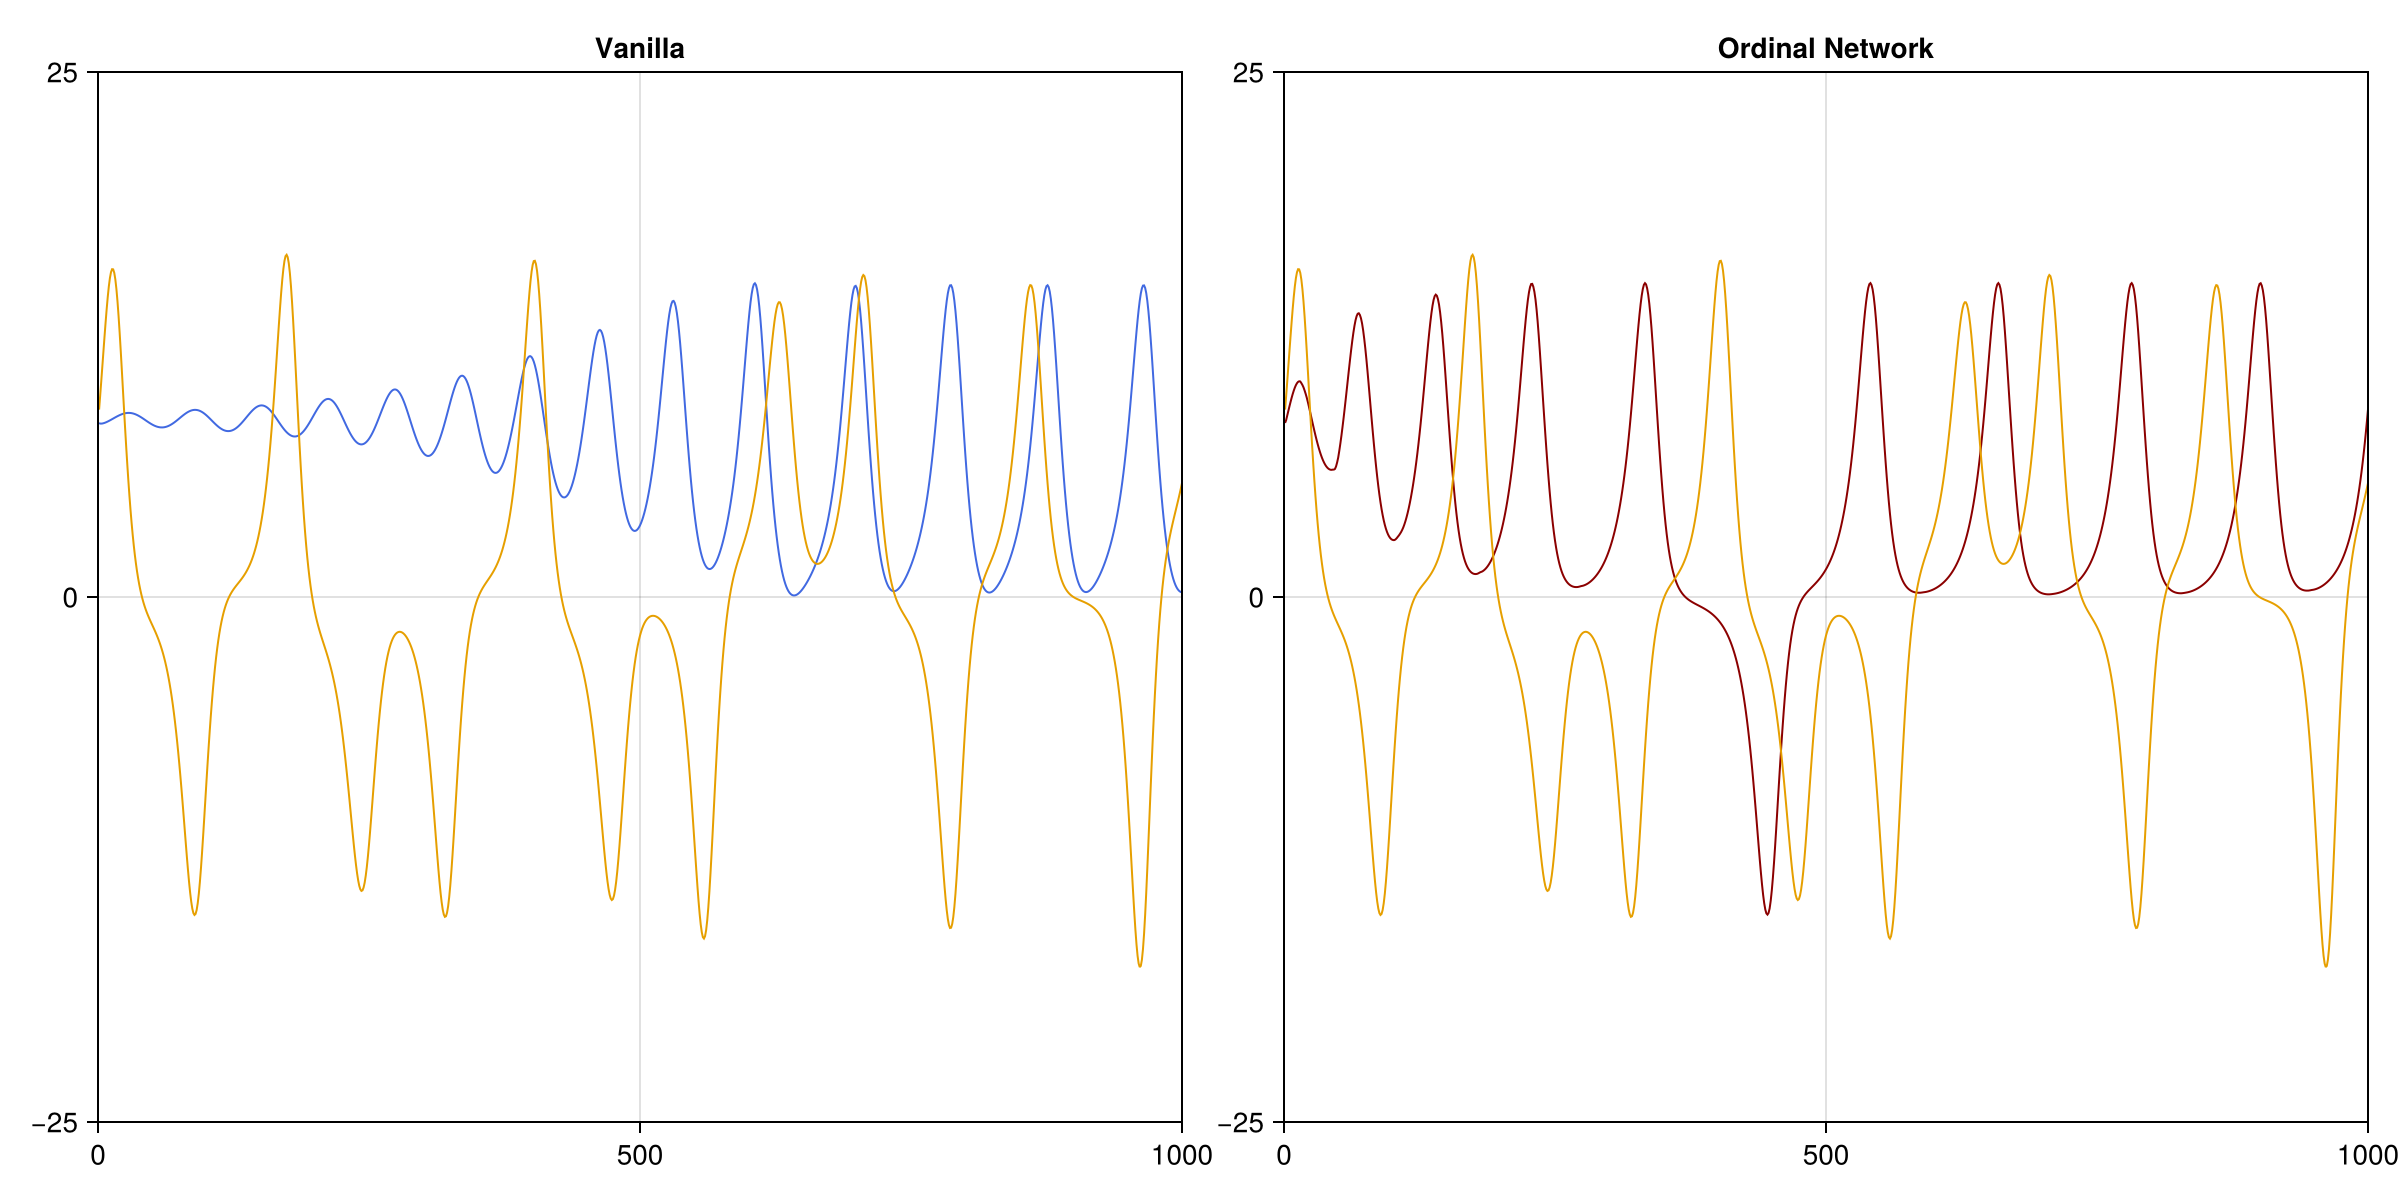

In [5]:
test_freerun(lo_train, lo_test, 4, 30; from=0, to=1000)

# Multi step predictions

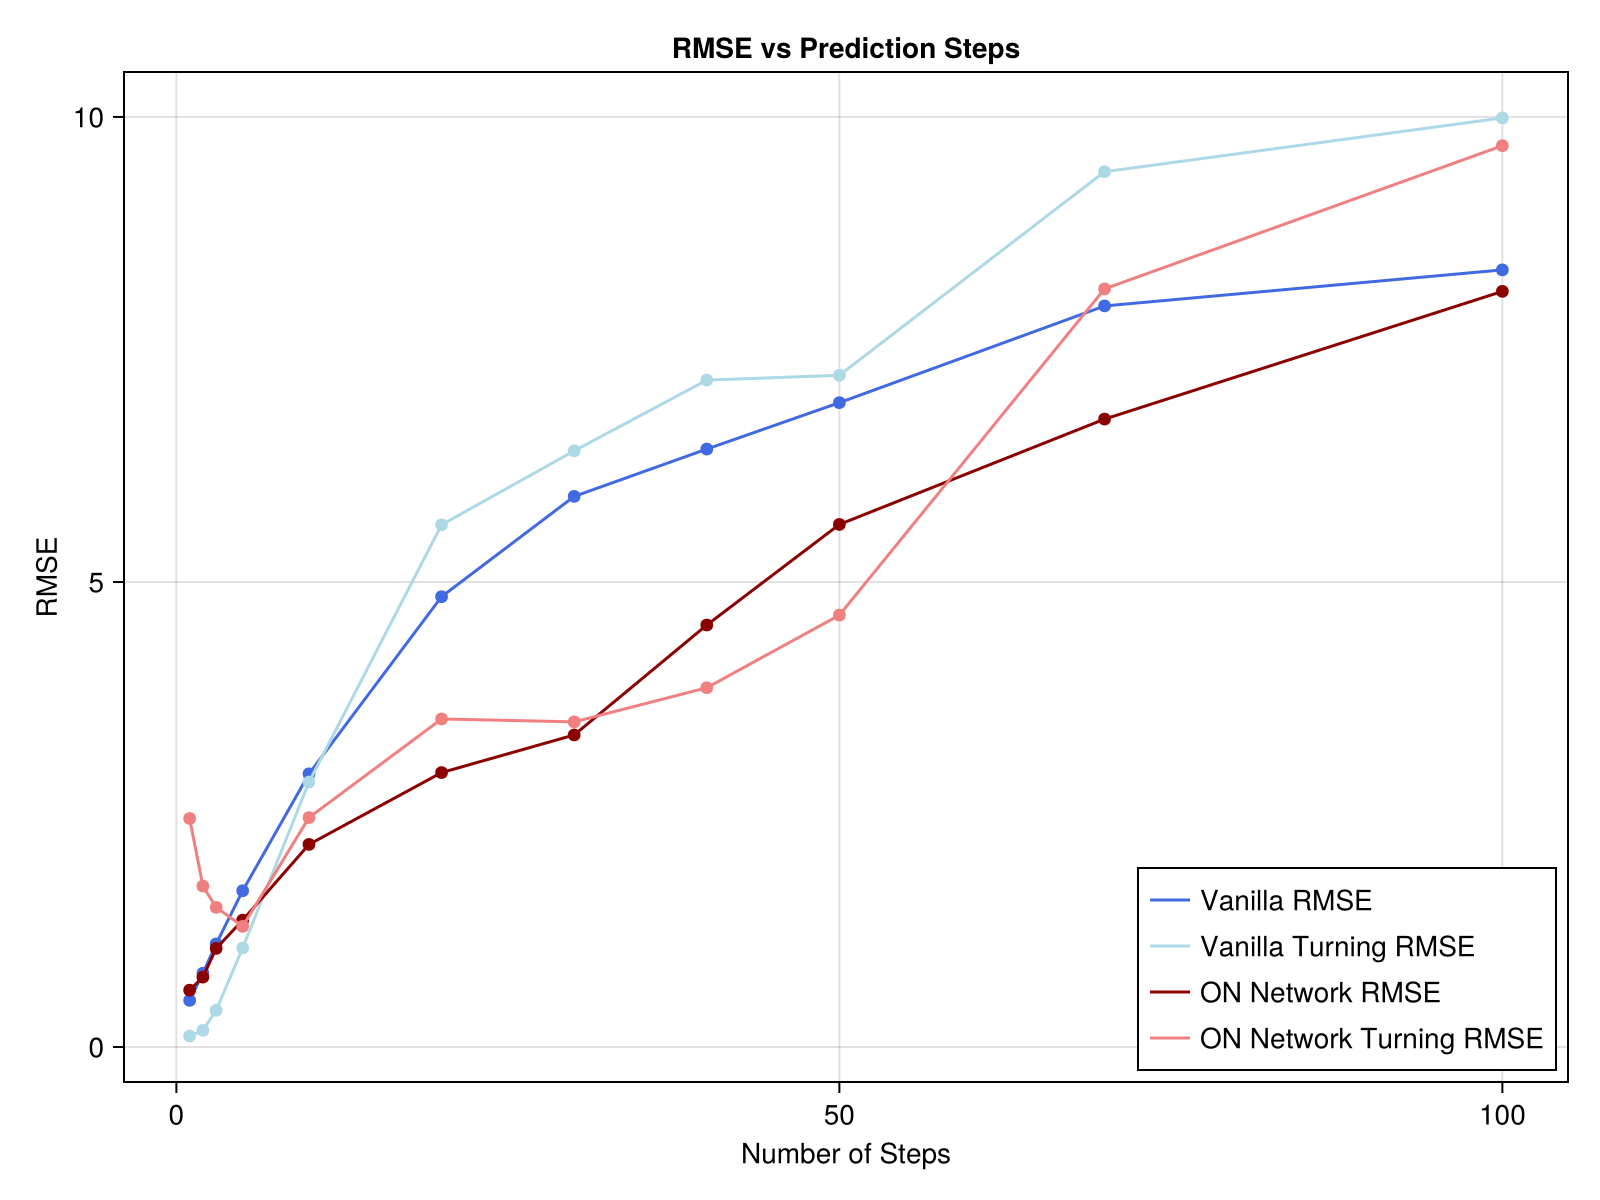

In [4]:
graph_multi_step_RMSE_vs_n_steps(lo_train, lo_test, [1, 2, 3, 5, 10, 20, 30, 40, 50, 70, 100], 3, 50; ignore_first=100, trials=30)

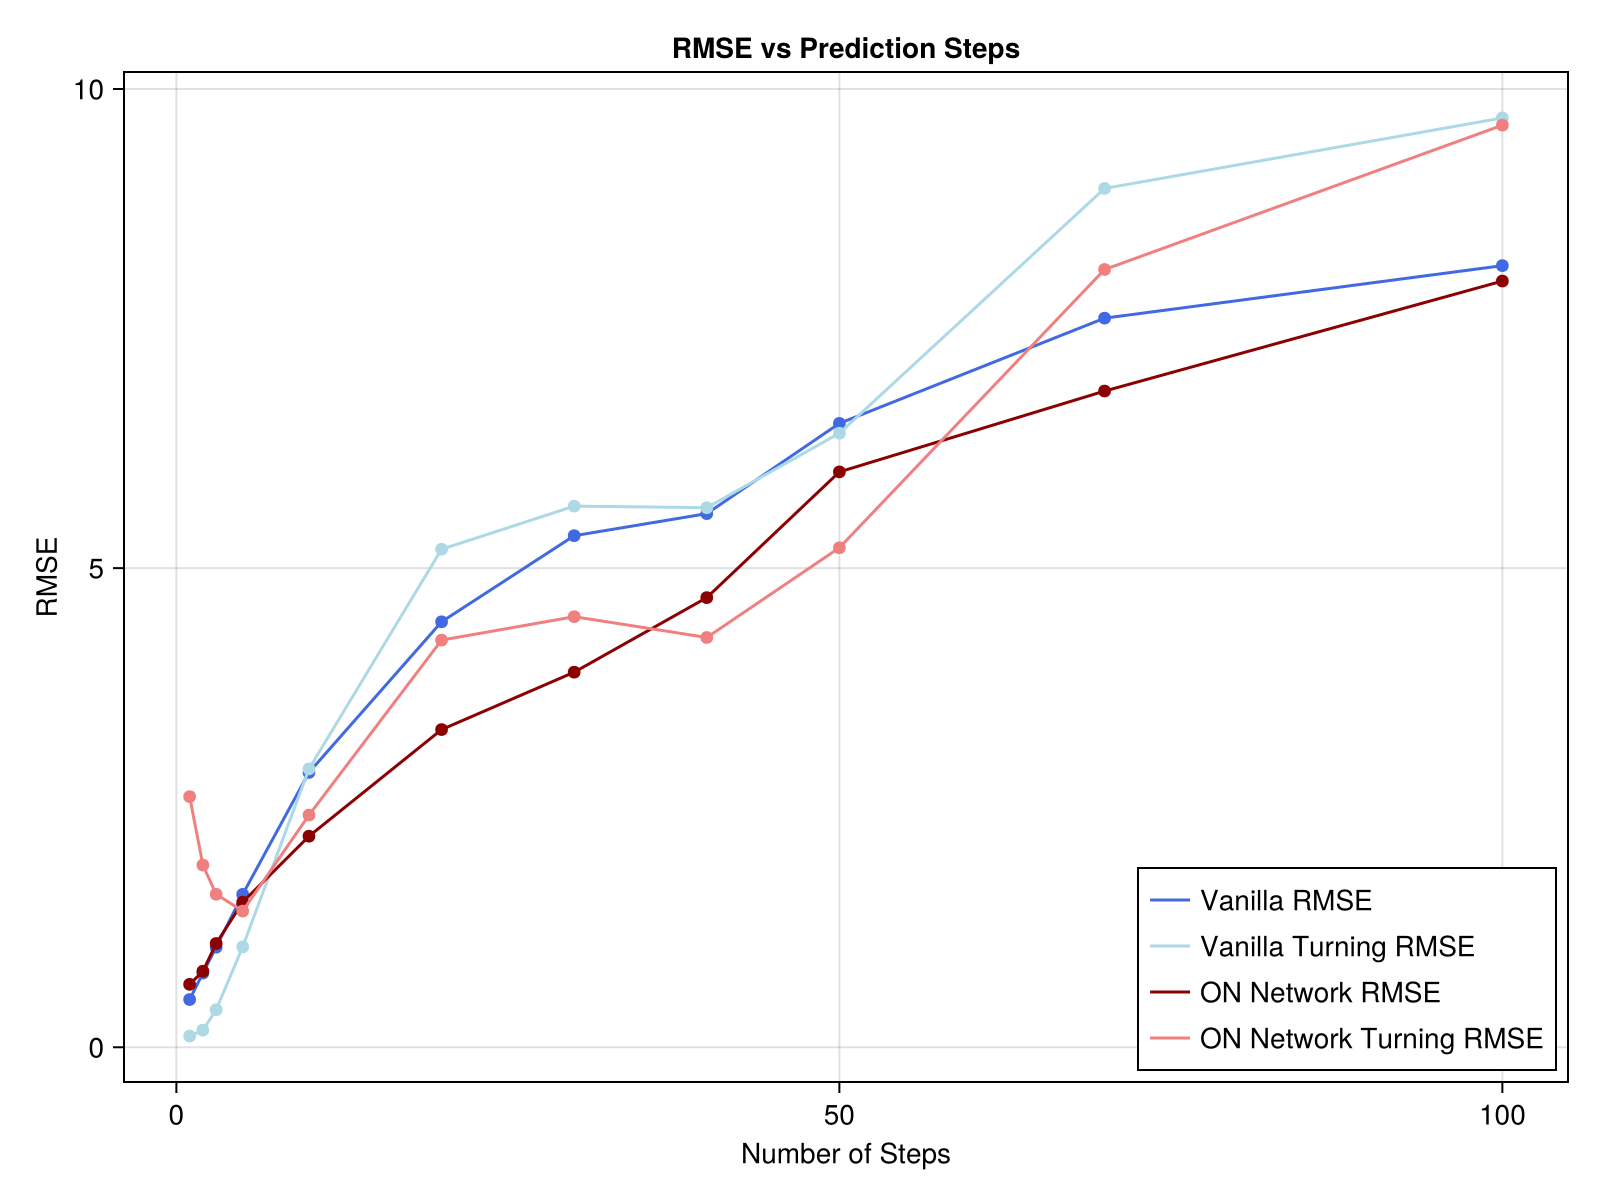

In [5]:
graph_multi_step_RMSE_vs_n_steps(lo_train, lo_test, [1, 2, 3, 5, 10, 20, 30, 40, 50, 70, 100], 3, 100; ignore_first=100, trials=30)

In [ ]:
graph_multi_step_RMSE_vs_n_steps(lo_train, lo_test, [1, 2, 3, 5, 10, 20, 30, 40, 50, 70, 100], 3, 300; ignore_first=100, trials=30)

Created reservoir of size: (1800,)
Created reservoir of size: (1800,)
Created reservoir of size: (1800,)
Created reservoir of size: (1800,)
Created reservoir of size: (1800,)
Created reservoir of size: (1800,)
Created reservoir of size: (1800,)
Created reservoir of size: (1800,)
Created reservoir of size: (1800,)
Created reservoir of size: (1800,)
Created reservoir of size: (1800,)
Created reservoir of size: (1800,)
Created reservoir of size: (1800,)
Created reservoir of size: (1800,)
Created reservoir of size: (1800,)
Created reservoir of size: (1800,)
Created reservoir of size: (1800,)
Created reservoir of size: (1800,)
Created reservoir of size: (1800,)
Created reservoir of size: (1800,)
Created reservoir of size: (1800,)
Created reservoir of size: (1800,)
Created reservoir of size: (1800,)
Created reservoir of size: (1800,)


In [ ]:
graph_multi_step_RMSE_vs_n_steps(lo_train, lo_test, [1, 2, 3, 5, 10, 20, 30, 40, 50, 70, 100], 4, 100; ignore_first=100, trials=30)

In [ ]:
graph_multi_step_RMSE_vs_n_steps(lo_train, lo_test, [1, 2, 3, 5, 10, 20, 30, 40, 50, 70, 100], 4, 250; ignore_first=100, trials=30)

In [ ]:
test_multi_step(lo_train, lo_test, 3, 100, n_steps=50, from=0, to=600; ignore_first=100)

In [ ]:
test_multi_step(lo_train, lo_test, 4, 100, n_steps=20, from=100, to=500)

In [ ]:
test_multi_step(lo_train, lo_test, 3, 400, n_steps=4, from=0, to=100)